# Predicting energy production

* gemini, gpt4, dartsの各TCN modelで電力生産量を予測して、結果を比較する
* data
    * /content/drive/MyDrive/study_DeepLearning/data/energy_dataset.csv

* darts サイト
    * https://unit8.com/resources/temporal-convolutional-networks-and-forecasting/

# 比較結果
* Darts版が、一番振幅を捕らえられている！！！

# Darts edition
* https://unit8.com/resources/temporal-convolutional-networks-and-forecasting/
* code:
    * https://github.com/unit8co/darts/blob/develop-bak/examples/10-DeepTCN-examples.ipynb

## load data & make features

In [ ]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 805.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1

In [ ]:
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import GaussianLikelihood
from darts.models import TCNModel
import pandas as pd
import matplotlib.pyplot as plt
# from darts.datasets import EnergyDataset

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/study_DeepLearning/data/energy_dataset.csv')
df['time'] = pd.to_datetime(df['time'], utc=True)
df['time'] = df['time'].dt.tz_localize(None)
df.set_index('time', inplace=True)
df.head(2)

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.1,65.41
2015-01-01 00:00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.1,64.92


In [ ]:
# 日ごとにグループ化
df_day_avg = df.groupby(df.index.astype(str).str.split(" ").str[0]).mean().reset_index()
df_day_avg.head(3)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2014-12-31,447.000000,329.000000,0.0,4844.000000,4821.000000,162.000000,0.0,0.0,0.0,...,196.000000,0.0,6378.000000,17.000000,NaN,6436.000000,26118.000000,25385.000000,50.100000,65.410000
1,2015-01-01,425.208333,243.708333,0.0,4187.791667,4099.458333,161.500000,0.0,0.0,0.0,...,201.041667,0.0,3994.000000,1049.500000,NaN,3942.416667,24753.250000,23966.958333,45.031667,62.090833
2,2015-01-02,389.875000,0.000000,0.0,3566.166667,1258.125000,200.833333,0.0,0.0,0.0,...,186.583333,0.0,11060.041667,1187.208333,NaN,11117.041667,27519.416667,27188.541667,17.598333,69.443750


In [ ]:
# fill missing value
series_en = fill_missing_values(
    TimeSeries.from_dataframe(df_day_avg, 'time', ['generation hydro run-of-river and poundage']), 'auto')

# slcaling
sclaer_en = Scaler()
series_en_transformed = sclaer_en.fit_transform(series_en)
train_en_transformed, val_en_transformed = series_en_transformed.split_after(pd.Timestamp('20170901'))

# add the day as a covariate
day_series = datetime_attribute_timeseries(
    series_en_transformed, attribute="day", one_hot=True,)
scaler_day = Scaler()
day_series_scaled = scaler_day.fit_transform(day_series) # <- one_hotで0と1しかないのにScalerする意味が解らない？？？
train_day, val_day = day_series_scaled.split_after(pd.Timestamp('20170901'))

<Axes: xlabel='time'>

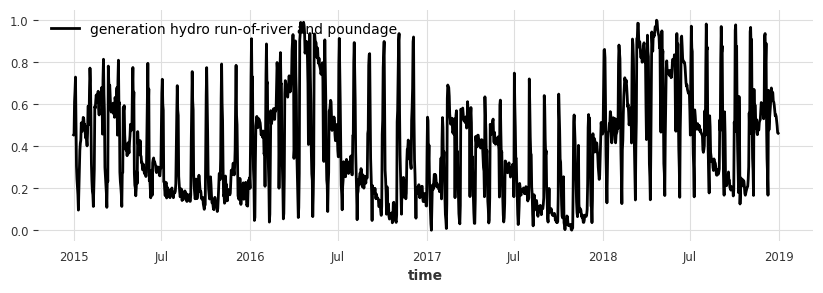

In [ ]:
plt.figure(figsize=(10, 3))
series_en_transformed.plot()

In [ ]:
# 作成した特徴量の確認
day_series.pd_dataframe().head(5)

component,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2015-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-02,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-03,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# # gpt版、gemini版での利用のため保存
# df_energy = series_en_transformed.pd_dataframe()
# future_df = day_series.pd_dataframe()
# merged_df = df_energy.join(future_df)
# merged_df.to_parquet('/content/drive/MyDrive/study_DeepLearning/data/energy_dataset_with_futures.paruqet')

## modeling

In [ ]:
deeptcn = TCNModel(
    dropout=0.2,
    batch_size=32,
    n_epochs=20,
    optimizer_kwargs={'lr': 1e-3},
    random_state=0,
    input_chunk_length=300,
    output_chunk_length=30,
    kernel_size=3,
    num_filters=4,
    likelihood=GaussianLikelihood(),
)

deeptcn.fit(train_en_transformed, past_covariates=train_day, verbose=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 1.2 K  | train
-------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=4, num_layers=None, dilation_base=2, weight_norm=False, dropout=0.2, batch_size=32, n_epochs=20, optimizer_kwargs={'lr': 0.001}, random_state=0, input_chunk_length=300, output_chunk_length=30, likelihood=GaussianLikelihood(prior_mu=None, prior_sigma=None, prior_strength=1.0, beta_nll=0.0))

In [ ]:
backtest_en = deeptcn.historical_forecasts(
    series_en_transformed,
    past_covariates=day_series_scaled,
    num_samples=50,
    start=0.7,
    forecast_horizon=30,
    stride=5,
    retrain=False,
    verbose=True,
    )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

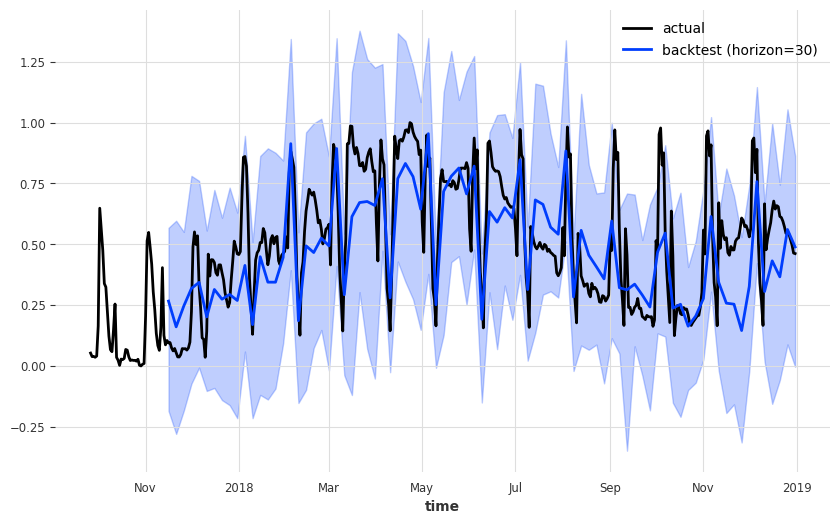

In [ ]:
plt.figure(figsize=(10,6))
series_en_transformed[1000:].plot(label='actual')
backtest_en.plot(
    label='backtest (horizon=30)',
    low_quantile=0.01,
    high_quantile=0.99)
plt.legend();

# Example1のモデル
* Temporal_Convolutional_Networks.ipynbのExample1


## Ordinal Padding Edition

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import Linear, Conv1d, ReLU, Dropout
from torch.nn import MSELoss
from torch.optim import Adam
import matplotlib.pyplot as plt

In [ ]:
# load data
data = pd.read_parquet('/content/drive/MyDrive/study_DeepLearning/data/energy_dataset_with_futures.paruqet')
data.head(3)

component,generation hydro run-of-river and poundage,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,...,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31,0.454234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2015-01-01,0.458010,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-02,0.613153,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data.shape

(1462, 32)

In [ ]:
# Hyperparameters
learning_rate = 0.001
epochs = 100
batch_size = 32
input_size = data.shape[1] # feature's numbers
n_channel = 16
output_size = 1
sequence_length = 300

In [ ]:
data = torch.tensor(data.to_numpy(), dtype=torch.float32)

# Dataset class Definition
class EnegyDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.sequence_length = seq_len

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.sequence_length, :]
        y = self.data[idx+self.sequence_length, 0]
        return x, y

# create dataset and dataloader
train_dataset = EnegyDataset(data[:1000], seq_len=sequence_length)
# ↓ we need former 300 records for sequence_length, so 700
val_dataset = EnegyDataset(data[700:], seq_len=sequence_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for x_batch, y_batch in train_dataloader:
    print(x_batch.shape)
    print(y_batch.shape)
    break

torch.Size([32, 300, 32])
torch.Size([32])


In [ ]:
for x_batch, y_batch in val_dataloader:
    print(x_batch.shape)
    print(y_batch.shape)
    break

torch.Size([32, 300, 32])
torch.Size([32])


In [ ]:
# Define the TCN model
class TCN(nn.Module):
    def __init__(self, input_size, num_channels, output_size, kernel_size=2, dropout=0.2):
        super(TCN, self).__init__()
        self.tcn = nn.Sequential(
            nn.Conv1d(in_channels=input_size,
                      out_channels=num_channels,
                      kernel_size=kernel_size,
                      padding=(kernel_size-1),
                      dilation=1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(in_channels=num_channels,
                      out_channels=output_size,
                      kernel_size=kernel_size,
                      padding=(kernel_size-1),
                      dilation=2),
            nn.ReLU(),
        )

    def forward(self, x):
        # Transpose to match input shape for Conv1D (batch_size, channels, seq_len)
        x = x.transpose(1, 2)
        x = self.tcn(x)
        return x[:, :, -1] # Return the last output for prediction

In [ ]:
# Model, loss, and Optimizer
model = TCN(input_size, n_channel, output_size, kernel_size=2, dropout=0.2)
criterion = MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_dataloader:
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_dataloader)}, Val Loss: {val_loss/len(val_dataloader)}")

print("Training complete")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch 1/100, Train Loss: 0.182545641945167, Val Loss: 0.2661698857943217
Epoch 2/100, Train Loss: 0.1375227988782254, Val Loss: 0.1806365327288707
Epoch 3/100, Train Loss: 0.09028712787072767, Val Loss: 0.11465308455129465
Epoch 4/100, Train Loss: 0.0659241813488982, Val Loss: 0.08023600180943807
Epoch 5/100, Train Loss: 0.059299207885156975, Val Loss: 0.07050605714321137
Epoch 6/100, Train Loss: 0.05533336763354865, Val Loss: 0.06916823759675025
Epoch 7/100, Train Loss: 0.05548620088533922, Val Loss: 0.06870806949834028
Epoch 8/100, Train Loss: 0.05485414510423487, Val Loss: 0.06748667893310388
Epoch 9/100, Train Loss: 0.05472261687232689, Val Loss: 0.06711030888060729
Epoch 10/100, Train Loss: 0.053820190697231075, Val Loss: 0.06631402845184008
Epoch 11/100, Train Loss: 0.05360537615012039, Val Loss: 0.06527487536271413
Epoch 12/100, Train Loss: 0.053139890120788055, Val Loss: 0.06484281818072
Epoch 13/100, Train Loss: 0.05292180832475424, Val Loss: 0.06421515184144179
Epoch 14/100, 

In [ ]:
model.eval()
predictions = []
targets = []
with torch.no_grad():
    for x_batch, y_batch in val_dataloader:
        outputs = model(x_batch)
        predictions.append(outputs.numpy())
        targets.append(y_batch.numpy())

predictions = np.concatenate(predictions).flatten()
targets = np.concatenate(targets).flatten()

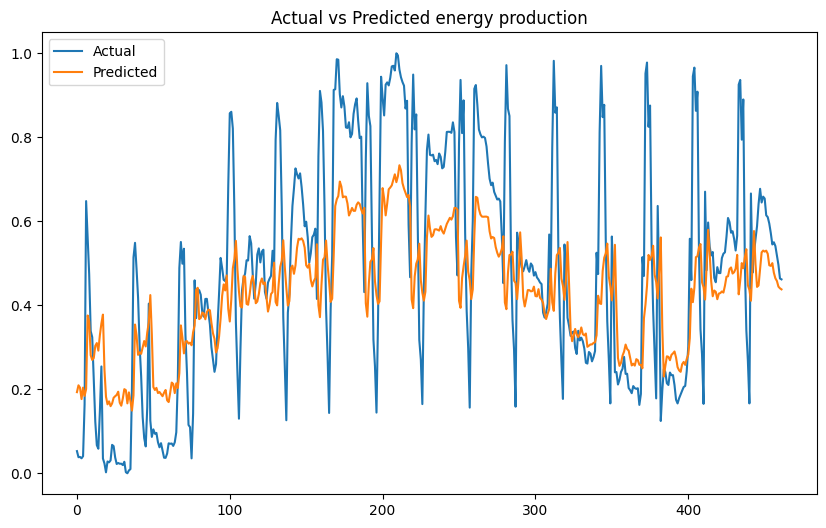

In [ ]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(targets, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted energy production')
plt.show()

## Left Padding Edition

# Example2(Gemini)のモデル


In [ ]:
# Model Definition
class TCNBlock(nn.Module):
    def __init__(self,
                 input_size,
                 n_channel,
                 kernel_size=3,
                 dropout=0.2):
        super(TCNBlock, self).__init__()
        pad = (kernel_size - 1) * 2
        self.conv1 = Conv1d(in_channels=input_size,
                            out_channels=n_channel,
                            kernel_size=kernel_size,
                            padding=pad)
        self.relu1 = ReLU()
        self.dropout1 = Dropout(dropout)
        self.dilated_conv = Conv1d(in_channels=n_channel,
                                   out_channels=n_channel,
                                   kernel_size=kernel_size,
                                   padding=pad,
                                   dilation=2)
        self.relu2 = ReLU()
        self.dropout2 = Dropout(dropout)
        self.skip_conn = Conv1d(in_channels=input_size,
                                out_channels=n_channel,
                                kernel_size=1,
                                padding=0)

    def forward(self, x):
        residual = self.skip_conn(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.dilated_conv(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        return x[:, :, :residual.size(2)] + residual # Trim x to match residual size if needed


class TCNModel(nn.Module):
    def __init__(self,
                 input_size,
                 n_channel,
                 output_size,
                 num_blocks=4,
                 dropout=0.2):
        super(TCNModel, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(Conv1d(in_channels=input_size,
                                  out_channels=n_channel,
                                  kernel_size=1)
        )
        for _ in range(num_blocks - 1):
            self.layers.append(TCNBlock(n_channel, n_channel, dropout=dropout))
        self.fc = Linear(in_features=n_channel, out_features=output_size)

    def forward(self, x):
        x = x.transpose(1, 2) # Transpose to match input shape for Conv1D (batch_size, channels, seq_len)
        for layer in self.layers:
            x = layer(x) # x.shape = Size(32, 16, 300)
        # x = x.mean(dim=2) # Average across the sequence length dimension
        x = x[:, :, -1] # x.shape = Size(32, 16)
        # return x
        return self.fc(x)

In [ ]:
# Hyperparameters
learning_rate = 0.001
epochs = 20
batch_size = 32
input_size = data.shape[1] # feature's numbers
n_channel = 16
output_size = 1
# sequence_length = 300

In [ ]:
# Model, loss, and Optimizer
model = TCNModel(input_size, n_channel, output_size)
criterion = MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for features, target in train_dataloader:
        optimizer.zero_grad()
        output = model(features)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, target in val_dataloader:
            output = model(features)
            loss = criterion(output, target)
            val_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_dataloader)}, Val Loss: {val_loss/len(val_dataloader)}')

print("Training complete!")

Epoch 1/20, Train Loss: 0.18827586629512635, Val Loss: 0.08006199188530445
Epoch 2/20, Train Loss: 0.06875960706648501, Val Loss: 0.10732781191666921
Epoch 3/20, Train Loss: 0.07223371890458194, Val Loss: 0.08623563063641389
Epoch 4/20, Train Loss: 0.06523624037138441, Val Loss: 0.08835871716340384
Epoch 5/20, Train Loss: 0.06734935736114328, Val Loss: 0.08402780555188656
Epoch 6/20, Train Loss: 0.06415386633439497, Val Loss: 0.08160689622163772
Epoch 7/20, Train Loss: 0.06545892383225939, Val Loss: 0.08047509007155895
Epoch 8/20, Train Loss: 0.06211039847271009, Val Loss: 0.07646216750144959
Epoch 9/20, Train Loss: 0.06089792849326676, Val Loss: 0.07380209763844808
Epoch 10/20, Train Loss: 0.05916499862955375, Val Loss: 0.06990615725517273
Epoch 11/20, Train Loss: 0.05706887624480508, Val Loss: 0.06516428651909033
Epoch 12/20, Train Loss: 0.056487139060416004, Val Loss: 0.061657906696200374
Epoch 13/20, Train Loss: 0.05323350421068343, Val Loss: 0.05439289597173532
Epoch 14/20, Train 

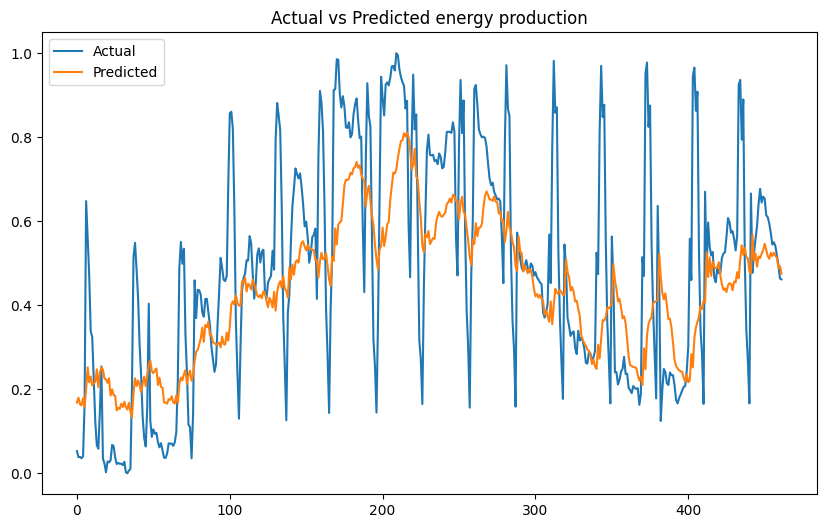

In [ ]:
model.eval()
predictions = []
targets = []
with torch.no_grad():
    for x_batch, y_batch in val_dataloader:
        outputs = model(x_batch)
        predictions.append(outputs.numpy())
        targets.append(y_batch.numpy())

predictions = np.concatenate(predictions).flatten()
targets = np.concatenate(targets).flatten()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(targets, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted energy production')
plt.show()

# Example3(gpt4o)のモデル

In [ ]:
# model definition
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 dilation,
                 padding):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels,
                               out_channels,
                               kernel_size,
                               stride=stride,
                               padding=padding,
                               dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(out_channels,
                               out_channels,
                               kernel_size,
                               stride=stride,
                               padding=padding,
                               dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.net = nn.Sequential(self.conv1,
                                 self.chomp1,
                                 self.relu1,
                                 self.conv2,
                                 self.chomp2,
                                 self.relu2)
        self.downsample = nn.Conv1d(in_channels,
                                    out_channels,
                                    1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self,
                 num_inputs,
                 num_channels,
                 kernel_size=2,
                 dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels,
                                     out_channels,
                                     kernel_size,
                                     stride=1,
                                     dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size)
            ]
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class TCNModel(nn.Module):
    def __init__(self,
                 num_inputs,
                 num_channels,
                 output_size,
                 kernel_size=2,
                 dropout=0.2):
        super(TCNModel, self).__init__()
        self.tcn = TemporalConvNet(num_inputs, num_channels, kernel_size, dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        y1 = self.tcn(x)
        return self.linear(y1[:, :, -1])

In [ ]:
# Hyperparameters
learning_rate = 0.001
epochs = 50
batch_size = 32
num_inputs = data.shape[1] # feature's numbers
# num_channels = [25, 25, 25, 25]
num_channels = [25]
output_size = 1

# sequence_length = 300

In [ ]:
model = TCNModel(num_inputs, num_channels, output_size)
criterion = MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for features, target in train_dataloader:
        features = features.permute(0, 2, 1)  # Change shape to (batch_size, num_inputs, sequence_length)
        optimizer.zero_grad()
        output = model(features)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, target in val_dataloader:
            features = features.permute(0, 2, 1)  # Change shape to (batch_size, num_inputs, sequence_length)
            output = model(features)
            loss = criterion(output, target)
            val_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_dataloader)}, Val Loss: {val_loss/len(val_dataloader)}')

print("Training complete!")

Epoch 1/50, Train Loss: 0.11374771925197406, Val Loss: 0.1117682850609223
Epoch 2/50, Train Loss: 0.06508642765270038, Val Loss: 0.07293680806954701
Epoch 3/50, Train Loss: 0.05616064445877617, Val Loss: 0.07391492115954558
Epoch 4/50, Train Loss: 0.055199635215103626, Val Loss: 0.07187047166128953
Epoch 5/50, Train Loss: 0.05415330429307439, Val Loss: 0.06863320854802926
Epoch 6/50, Train Loss: 0.05294646094129844, Val Loss: 0.06631439290940762
Epoch 7/50, Train Loss: 0.05202452203428203, Val Loss: 0.06382804351548353
Epoch 8/50, Train Loss: 0.05107041397555308, Val Loss: 0.061407904326915744
Epoch 9/50, Train Loss: 0.050119383853267536, Val Loss: 0.05914978471895059
Epoch 10/50, Train Loss: 0.0492689980363304, Val Loss: 0.0571820218116045
Epoch 11/50, Train Loss: 0.04851374741305004, Val Loss: 0.05557530069102844
Epoch 12/50, Train Loss: 0.04793791439045559, Val Loss: 0.05415258320669333
Epoch 13/50, Train Loss: 0.04742725879292597, Val Loss: 0.05315453180422385
Epoch 14/50, Train Lo

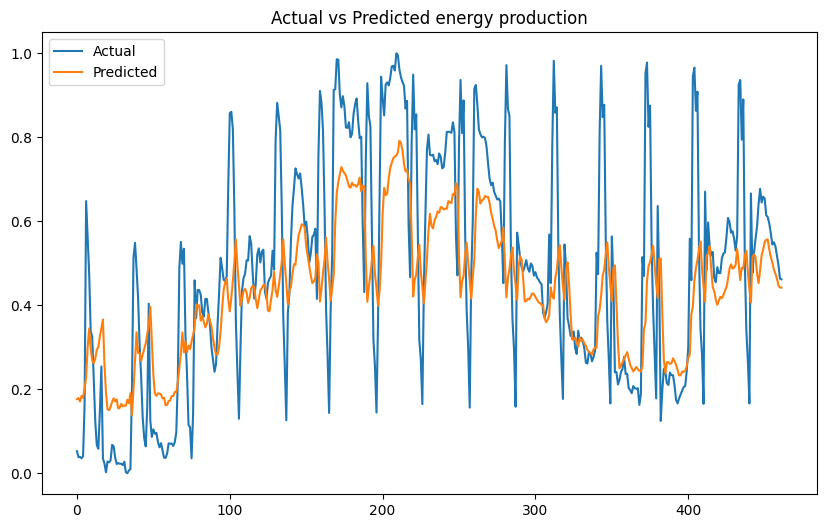

In [ ]:
model.eval()
predictions = []
targets = []
with torch.no_grad():
    for x_batch, y_batch in val_dataloader:
        x_batch = x_batch.permute(0, 2, 1)
        outputs = model(x_batch)
        predictions.append(outputs.numpy())
        targets.append(y_batch.numpy())

predictions = np.concatenate(predictions).flatten()
targets = np.concatenate(targets).flatten()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(targets, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted energy production')
plt.show()